# Обучение сиамской сети для различия двух объектов

Обучение на данных MOT20Ext

In [1]:
import albumentations as A
import matplotlib.pyplot as plt
import torch
from torch.optim import Adam
from torchvision import models
import pandas as pd
from os.path import join

from src.config import MOT20_EXT_FIRST_AXIS_MEAN, MOT20_EXT_SECOND_AXIS_MEAN
from src.models import (SiameseTransfered, resnet_grad_l4_unlock,
                        resnet_grad_linear_unlock)
from src.train import (ContrastiveLoss, display_images, get_loaders,
                       train_siamese)
from src.transforms import get_norm_transform, get_resize_transform

## Загрузка данных

### Загрузка трансорфмаций

In [2]:
resize_transform = get_resize_transform((MOT20_EXT_FIRST_AXIS_MEAN, MOT20_EXT_SECOND_AXIS_MEAN)) 
norm_transform = get_norm_transform()
transform = A.Compose([resize_transform, norm_transform])

### Загрузка конфига

In [3]:
dataset_config = {
    'dataset_config': 'mot20_ext-v1a',
    'dataset': 'mot20_ext',
    'dataset_use': 0.002,
    'val_proportion': 0.1,
    'test_proportion': 0.2,
    'batch_size': 16,
    'extra_parameters': {
        'visibility_threshold': 1,
        'negative_proportion': 0.5,
        'frame_distance': 0
    }
}

In [4]:
train_loader, val_loader, test_loader = get_loaders(dataset_config, transform=transform)

### Проверка отображения

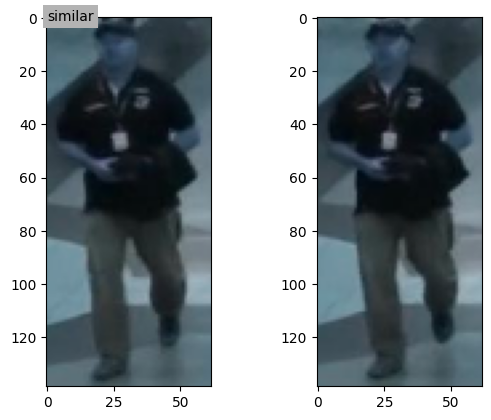

In [5]:
batch = next(iter(train_loader))
x1, x2, y = batch[0][0], batch[1][0], batch[2][0]
display_images((x1, x2), y)

In [6]:
# batch = next(iter(train_loader))
# display_batch(batch)

## Обучение

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/nick/reidentification/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


### Обучение Siamese over ResNet18, layer4 unfreeze

Параметры:
- Adam
- ContrastiveLoss
- Threshold = 0.25
- LR = 0.001 

In [8]:
model_rn18_l4 = SiameseTransfered(
    models.resnet18(pretrained=True),
    freeze_grad_fn=resnet_grad_l4_unlock,
    name='siamese_resnet18_linear'
)
model_rn18_l4 = model_rn18_l4.to(device)
lr = 1e-3
criterion = ContrastiveLoss()
optimizer = Adam(model_rn18_l4.parameters(), lr)

/home/nick/reidentification/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nick/reidentification/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
model, results = train_siamese(
    config=dataset_config,
    criterion=criterion,
    device=device,
    epoch_count=2,
    lr=lr,
    model=model_rn18_l4,
    optimizer=optimizer,
    threshold=0.25,
    train_loader=train_loader,
    val_loader=val_loader,
)

Epoch 0/1:


100%|██████████| 23/23 [00:07<00:00,  3.26it/s]

train Loss: 876.4270 Acc: 0.9022



100%|██████████| 3/3 [00:00<00:00,  6.31it/s]

val Loss: 63.4721 Acc: 0.9792


Model saved at siamese_resnet18_linear.pth
Epoch 1/1:


100%|██████████| 23/23 [00:06<00:00,  3.30it/s]

train Loss: 20.4928 Acc: 0.9293



100%|██████████| 3/3 [00:00<00:00,  5.87it/s]

val Loss: 14.5473 Acc: 0.9583


In [ ]:
file_path = join(RESULTS_PATH, 'experiments.csv')
config_path = join(RESULTS_PATH, 'configs.csv')
exp_df = pd.read_csv(file_path)
exp_df

### Обучение Siamese over ResNet18, last linear only

In [ ]:
model_rn18_linear = SiameseTransfered(
    models.resnet18(pretrained=True),
    freeze_grad_fn=resnet_grad_linear_unlock,
    name='siamese_resnet18_linear'
)

lr = 1e-2
criterion = ContrastiveLoss()
optimizer = Adam(model.parameters(), lr)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model, results = train(
    model=model,
    criterion=criterion,
    device=device,
    train_loader=train_loader,
    val_loader=val_loader,
    epoch_count=3,
    optimizer=optimizer,
    threshold=0.25
)

Epoch 0/2:


100%|██████████| 22/22 [00:11<00:00,  1.88it/s]

train Loss: 2298.1805 Acc: 0.7301



100%|██████████| 5/5 [00:02<00:00,  2.13it/s]

val Loss: 1708.0820 Acc: 0.7250
Model saved at resnet_l4.pth
Epoch 1/2:



100%|██████████| 22/22 [00:11<00:00,  1.95it/s]

train Loss: 993.2562 Acc: 0.7273



100%|██████████| 5/5 [00:02<00:00,  2.03it/s]

val Loss: 917.9447 Acc: 0.7875
Model saved at resnet_l4.pth
Epoch 2/2:



100%|██████████| 22/22 [00:10<00:00,  2.00it/s]

train Loss: 533.1695 Acc: 0.7642



100%|██████████| 5/5 [00:02<00:00,  2.19it/s]

val Loss: 474.1536 Acc: 0.7125


### Обучение BasicCNN

In [ ]:
model = 
lr = 0.1
criterion = ContrastiveLoss()
optimizer = Adam(model.parameters(), lr)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

model, results = train(
    model=model,
    criterion=criterion,
    device=device,
    train_loader=train_loader,
    val_loader=val_loader,
    epoch_count=10,
    optimizer=optimizer,
    threshold=0.25
)

Epoch 0/9:


100%|██████████| 22/22 [00:23<00:00,  1.07s/it]

train Loss: 11.2927 Acc: 0.6818



100%|██████████| 5/5 [00:00<00:00,  7.55it/s]

val Loss: 2.4559 Acc: 0.9000
Model saved at basic_cnn.pth
Epoch 1/9:



100%|██████████| 22/22 [00:24<00:00,  1.09s/it]

train Loss: 1.4874 Acc: 0.6619



100%|██████████| 5/5 [00:00<00:00,  7.93it/s]

val Loss: 1.5503 Acc: 0.8250
Epoch 2/9:



100%|██████████| 22/22 [00:23<00:00,  1.07s/it]

train Loss: 1.3579 Acc: 0.6818



100%|██████████| 5/5 [00:00<00:00,  7.26it/s]

val Loss: 1.6998 Acc: 0.8625
Epoch 3/9:



100%|██████████| 22/22 [00:25<00:00,  1.15s/it]

train Loss: 1.3846 Acc: 0.6705



100%|██████████| 5/5 [00:00<00:00,  6.94it/s]

val Loss: 1.4850 Acc: 0.9375
Model saved at basic_cnn.pth
Epoch 4/9:



100%|██████████| 22/22 [00:25<00:00,  1.15s/it]

train Loss: 1.4048 Acc: 0.7273



100%|██████████| 5/5 [00:00<00:00,  7.63it/s]

val Loss: 1.5470 Acc: 0.8125
Epoch 5/9:



100%|██████████| 22/22 [00:25<00:00,  1.18s/it]

train Loss: 1.4186 Acc: 0.7216



100%|██████████| 5/5 [00:00<00:00,  6.96it/s]

val Loss: 1.7108 Acc: 0.8500
Epoch 6/9:



100%|██████████| 22/22 [00:24<00:00,  1.11s/it]

train Loss: 1.4180 Acc: 0.7045



100%|██████████| 5/5 [00:00<00:00,  7.66it/s]

val Loss: 1.5746 Acc: 0.7250
Epoch 7/9:



100%|██████████| 22/22 [00:23<00:00,  1.06s/it]

train Loss: 1.3072 Acc: 0.6477



100%|██████████| 5/5 [00:00<00:00,  6.96it/s]

val Loss: 1.5091 Acc: 0.9125
Epoch 8/9:



100%|██████████| 22/22 [00:23<00:00,  1.07s/it]

train Loss: 1.3695 Acc: 0.6705



100%|██████████| 5/5 [00:00<00:00,  7.79it/s]

val Loss: 1.4572 Acc: 0.9375
Epoch 9/9:



100%|██████████| 22/22 [00:23<00:00,  1.09s/it]

train Loss: 1.4502 Acc: 0.7415



100%|██████████| 5/5 [00:00<00:00,  7.63it/s]

val Loss: 1.5912 Acc: 0.7750


### Результаты

In [ ]:
def draw_plot(y1, y2, label):
    epoch = range(len(y1))
    fig, ax = plt.subplots()
    ax.plot(epoch, y1, label=f'{label} loss')
    ax.plot(epoch, y2, label=f'{label} accuracy')
    ax.grid()
    plt.xlabel('epoch count')
    plt.ylabel('metrics')
    plt.title(label)
    plt.legend()
    fig.savefig("test.png")
    plt.show()

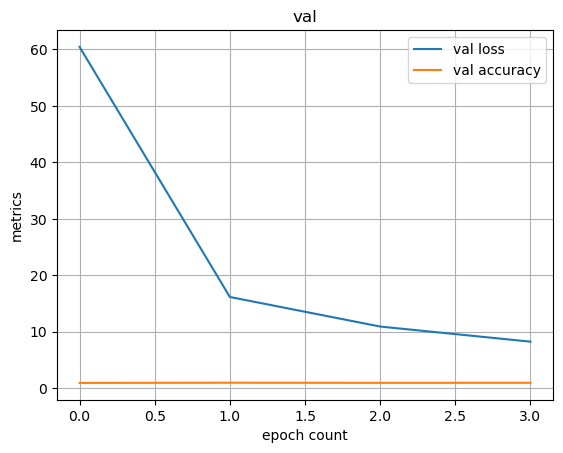

In [ ]:
draw_plot(results['val'][0], results['val'][1], 'val')